In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [2]:
# Step 1: Load and preprocess the data
data = pd.read_csv('Training_data_uhi_index_UHI2025-v2.csv')  # Replace with your dataset

In [3]:
data

Longitude   Latitude          datetime  UHI Index
0     -73.909167  40.813107  24-07-2021 15:53   1.030289
1     -73.909187  40.813045  24-07-2021 15:53   1.030289
2     -73.909215  40.812978  24-07-2021 15:53   1.023798
3     -73.909242  40.812908  24-07-2021 15:53   1.023798
4     -73.909257  40.812845  24-07-2021 15:53   1.021634
...          ...        ...               ...        ...
11224 -73.957050  40.790333  24-07-2021 15:57   0.972470
11225 -73.957063  40.790308  24-07-2021 15:57   0.972470
11226 -73.957093  40.790270  24-07-2021 15:57   0.981124
11227 -73.957112  40.790253  24-07-2021 15:59   0.981245
11228 -73.957128  40.790237  24-07-2021 15:59   0.983408

[11229 rows x 4 columns]

# LANDSAT LST

In [4]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import jet,RdYlGn

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load

In [5]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

time_window = "2021-06-01/2022-06-01"

In [6]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["landsat-c2-l2"],
    query={"eo:cloud_cover": {"lt": 20},"platform": {"in": ["landsat-8"]}},
)

In [7]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 16


In [8]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [9]:
resolution = 4  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

In [10]:
data1 = stac_load(
    items,
    bands=["red", "green", "blue","swir16","nir08"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [11]:
data1 = data1.persist()

In [12]:
scale1 = 0.0000275 
offset1 = -0.2 
data1 = data1.astype(float) * scale1 + offset1

In [13]:
scene = 2

In [14]:
ndvi_data = (data1.isel(time=scene).nir08-data1.isel(time=scene).red)/(data1.isel(time=scene).nir08+data1.isel(time=scene).red)

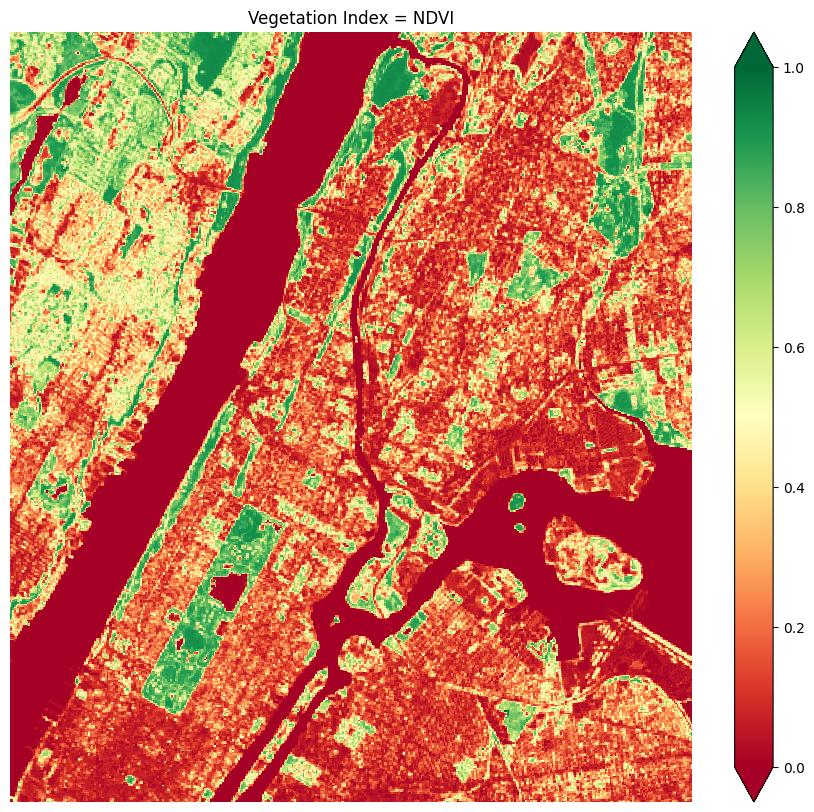

In [15]:
fig, ax = plt.subplots(figsize=(11,10))
ndvi_data.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Vegetation Index = NDVI")
plt.axis('off')
plt.show()

In [16]:
data3 = data1.isel(time=scene)

In [17]:
height = data3.dims["latitude"]
width = data3.dims["longitude"]

In [18]:
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data3.rio.write_crs("epsg:4326", inplace=True)
data3.rio.write_transform(transform=gt, inplace=True);

In [19]:
df_vland = data3.to_dataframe().reset_index()
df_vland

latitude  longitude                       time       red     green  \
0         40.880004 -74.010007 2021-06-23 15:39:44.720711  0.066393  0.068317   
1         40.880004 -74.009971 2021-06-23 15:39:44.720711  0.066393  0.068317   
2         40.880004 -74.009935 2021-06-23 15:39:44.720711  0.066393  0.068317   
3         40.880004 -74.009899 2021-06-23 15:39:44.720711  0.066393  0.068317   
4         40.880004 -74.009863 2021-06-23 15:39:44.720711  0.066393  0.068317   
...             ...        ...                        ...       ...       ...   
15112939  40.750000 -73.860133 2021-06-23 15:39:44.720711  0.115425  0.103215   
15112940  40.750000 -73.860097 2021-06-23 15:39:44.720711  0.115425  0.103215   
15112941  40.750000 -73.860061 2021-06-23 15:39:44.720711  0.115425  0.103215   
15112942  40.750000 -73.860025 2021-06-23 15:39:44.720711  0.196660  0.167098   
15112943  40.750000 -73.859989 2021-06-23 15:39:44.720711  0.196660  0.167098   

              blue    swir16     nir08  spatial_ref  
0         0.045465  0.149855  0.227762            0  
1         0.045465  0.149855  0.227762            0  
2         0.045465  0.149855  0.227762            0  
3         0.045465  0.149855  0.227762            0  
4         0.045465  0.149855  0.227762            0  
...            ...       ...       ...          ...  
15112939  0.088200  0.154035  0.145977            0  
15112940  0.088200  0.154035  0.145977            0  
15112941  0.088200  0.154035  0.145977            0  
15112942  0.126865  0.272505  0.240193            0  
15112943  0.126865  0.272505  0.240193            0  

[15112944 rows x 9 columns]

In [20]:
df_vland["ndvi"] = (df_vland["nir08"] - df_vland["red"]) / (df_vland["nir08"] + df_vland["red"])

#NDBI = (SWIR-NIR) / (SWIR+NIR)
df_vland["ndbi"] = (df_vland["swir16"] - df_vland["nir08"]) / (df_vland["swir16"] + df_vland["nir08"])

#NDWI = (GREEN-NIR) / (GREEN+NIR)
df_vland["ndwi"] = (df_vland["green"] - df_vland["nir08"]) / (df_vland["green"] + df_vland["nir08"])

In [21]:
df_vland.drop(columns = ["red", "green", "blue","swir16","nir08", 'spatial_ref'],inplace = True)

In [22]:
df_vland

latitude  longitude                       time      ndvi      ndbi  \
0         40.880004 -74.010007 2021-06-23 15:39:44.720711  0.548588 -0.206313   
1         40.880004 -74.009971 2021-06-23 15:39:44.720711  0.548588 -0.206313   
2         40.880004 -74.009935 2021-06-23 15:39:44.720711  0.548588 -0.206313   
3         40.880004 -74.009899 2021-06-23 15:39:44.720711  0.548588 -0.206313   
4         40.880004 -74.009863 2021-06-23 15:39:44.720711  0.548588 -0.206313   
...             ...        ...                        ...       ...       ...   
15112939  40.750000 -73.860133 2021-06-23 15:39:44.720711  0.116879  0.026857   
15112940  40.750000 -73.860097 2021-06-23 15:39:44.720711  0.116879  0.026857   
15112941  40.750000 -73.860061 2021-06-23 15:39:44.720711  0.116879  0.026857   
15112942  40.750000 -73.860025 2021-06-23 15:39:44.720711  0.099650  0.063024   
15112943  40.750000 -73.859989 2021-06-23 15:39:44.720711  0.099650  0.063024   

              ndwi  
0        -0.538520  
1        -0.538520  
2        -0.538520  
3        -0.538520  
4        -0.538520  
...            ...  
15112939 -0.171604  
15112940 -0.171604  
15112941 -0.171604  
15112942 -0.179467  
15112943 -0.179467  

[15112944 rows x 6 columns]

# GETTING LST

In [23]:
data2 = stac_load(
    items,
    bands=["lwir11"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [24]:
data2 = data2.persist()

In [25]:
scale2 = 0.00341802 
offset2 = 149.0 
kelvin_celsius = 273.15 # convert from Kelvin to Celsius
data2 = data2.astype(float) * scale2 + offset2 - kelvin_celsius

In [26]:
display(data2)

<xarray.Dataset> Size: 2GB
Dimensions:      (latitude: 3619, longitude: 4176, time: 16)
Coordinates:
  * latitude     (latitude) float64 29kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 33kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 128B 2021-06-07T15:39:15.904901 ... 20...
Data variables:
    lwir11       (time, latitude, longitude) float64 2GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

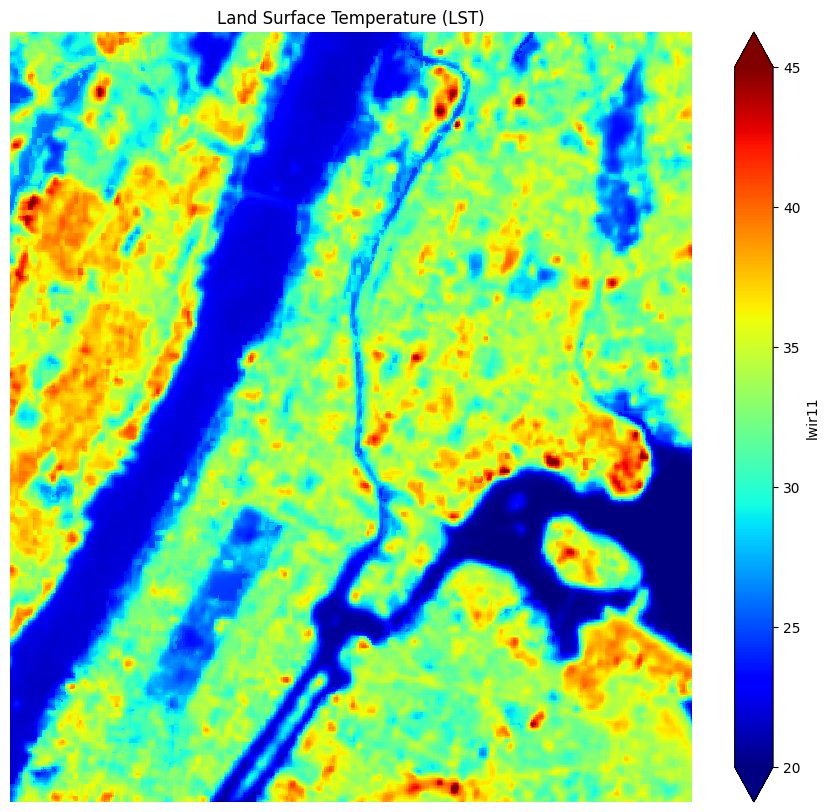

In [27]:
fig, ax = plt.subplots(figsize=(11,10))
data2.isel(time=scene).lwir11.plot.imshow(vmin=20.0, vmax=45.0, cmap="jet")
plt.title("Land Surface Temperature (LST)")
plt.axis('off')
plt.show()

In [28]:
data3 = data2.isel(time=scene)

In [29]:
height = data3.dims["latitude"]
width = data3.dims["longitude"]

In [30]:
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data3.rio.write_crs("epsg:4326", inplace=True)
data3.rio.write_transform(transform=gt, inplace=True);

In [31]:
df_lst = data3.to_dataframe().reset_index()
df_lst

latitude  longitude                       time     lwir11  \
0         40.880004 -74.010007 2021-06-23 15:39:44.720711  35.560403   
1         40.880004 -74.009971 2021-06-23 15:39:44.720711  35.560403   
2         40.880004 -74.009935 2021-06-23 15:39:44.720711  35.560403   
3         40.880004 -74.009899 2021-06-23 15:39:44.720711  35.560403   
4         40.880004 -74.009863 2021-06-23 15:39:44.720711  35.560403   
...             ...        ...                        ...        ...   
15112939  40.750000 -73.860133 2021-06-23 15:39:44.720711  34.117998   
15112940  40.750000 -73.860097 2021-06-23 15:39:44.720711  34.117998   
15112941  40.750000 -73.860061 2021-06-23 15:39:44.720711  34.117998   
15112942  40.750000 -73.860025 2021-06-23 15:39:44.720711  34.357259   
15112943  40.750000 -73.859989 2021-06-23 15:39:44.720711  34.357259   

          spatial_ref  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
15112939            0  
15112940            0  
15112941            0  
15112942            0  
15112943            0  

[15112944 rows x 5 columns]

# Combining Dataset for LandSAT

In [32]:
df_merged = pd.merge(df_lst, df_vland, on=["latitude", "longitude"])

In [33]:
df_merged.drop(columns = ['spatial_ref','time_y'], inplace = True)

In [34]:
df_merged

latitude  longitude                     time_x     lwir11  \
0         40.880004 -74.010007 2021-06-23 15:39:44.720711  35.560403   
1         40.880004 -74.009971 2021-06-23 15:39:44.720711  35.560403   
2         40.880004 -74.009935 2021-06-23 15:39:44.720711  35.560403   
3         40.880004 -74.009899 2021-06-23 15:39:44.720711  35.560403   
4         40.880004 -74.009863 2021-06-23 15:39:44.720711  35.560403   
...             ...        ...                        ...        ...   
15112939  40.750000 -73.860133 2021-06-23 15:39:44.720711  34.117998   
15112940  40.750000 -73.860097 2021-06-23 15:39:44.720711  34.117998   
15112941  40.750000 -73.860061 2021-06-23 15:39:44.720711  34.117998   
15112942  40.750000 -73.860025 2021-06-23 15:39:44.720711  34.357259   
15112943  40.750000 -73.859989 2021-06-23 15:39:44.720711  34.357259   

              ndvi      ndbi      ndwi  
0         0.548588 -0.206313 -0.538520  
1         0.548588 -0.206313 -0.538520  
2         0.548588 -0.206313 -0.538520  
3         0.548588 -0.206313 -0.538520  
4         0.548588 -0.206313 -0.538520  
...            ...       ...       ...  
15112939  0.116879  0.026857 -0.171604  
15112940  0.116879  0.026857 -0.171604  
15112941  0.116879  0.026857 -0.171604  
15112942  0.099650  0.063024 -0.179467  
15112943  0.099650  0.063024 -0.179467  

[15112944 rows x 7 columns]

In [35]:
value1 = []
value2 = []
value3 = []
value4 = []
for index, target_row in data.iterrows():
    target_longitude = data["Longitude"][index]
    target_latitude = data["Latitude"][index]

    # Calculate the Euclidean distance between the target and each row in the main dataset
    #print(target_longitude)
    df_merged['distance'] = np.sqrt((df_merged['longitude'] - target_longitude)**2 + (df_merged['latitude'] - target_latitude)**2)
    
    # Find the row with the minimum distance (closest)
    closest_row = df_merged.loc[df_merged['distance'].idxmin()]

    # Append the closest row to target_df or a new DataFrame
    #print(closest_row)
    value1.append(closest_row['lwir11'])
    value2.append(closest_row['ndvi'])
    value3.append(closest_row['ndbi'])
    value4.append(closest_row['ndwi'])

data['lst'] = value1
data['ndvi'] = value2
data['ndbi'] = value3
data['ndwi'] = value4


In [36]:
data

Longitude   Latitude          datetime  UHI Index        lst      ndvi  \
0     -73.909167  40.813107  24-07-2021 15:53   1.030289  34.097490  0.471610   
1     -73.909187  40.813045  24-07-2021 15:53   1.030289  34.097490  0.471610   
2     -73.909215  40.812978  24-07-2021 15:53   1.023798  34.097490  0.471610   
3     -73.909242  40.812908  24-07-2021 15:53   1.023798  34.097490  0.471610   
4     -73.909257  40.812845  24-07-2021 15:53   1.021634  33.950515  0.455214   
...          ...        ...               ...        ...        ...       ...   
11224 -73.957050  40.790333  24-07-2021 15:57   0.972470  27.863021  0.724802   
11225 -73.957063  40.790308  24-07-2021 15:57   0.972470  27.863021  0.724802   
11226 -73.957093  40.790270  24-07-2021 15:57   0.981124  27.863021  0.724802   
11227 -73.957112  40.790253  24-07-2021 15:59   0.981245  27.863021  0.724802   
11228 -73.957128  40.790237  24-07-2021 15:59   0.983408  27.863021  0.724802   

           ndbi      ndwi  
0     -0.189825 -0.472665  
1     -0.189825 -0.472665  
2     -0.189825 -0.472665  
3     -0.189825 -0.472665  
4     -0.146109 -0.447358  
...         ...       ...  
11224 -0.302773 -0.673683  
11225 -0.302773 -0.673683  
11226 -0.302773 -0.673683  
11227 -0.302773 -0.673683  
11228 -0.302773 -0.673683  

[11229 rows x 8 columns]

# SATELITE

In [37]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 10}},
)

In [38]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 42


In [39]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [40]:
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

In [41]:
data_satelite = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [42]:
plot_data = data_satelite[["B04","B03","B02"]].to_array()

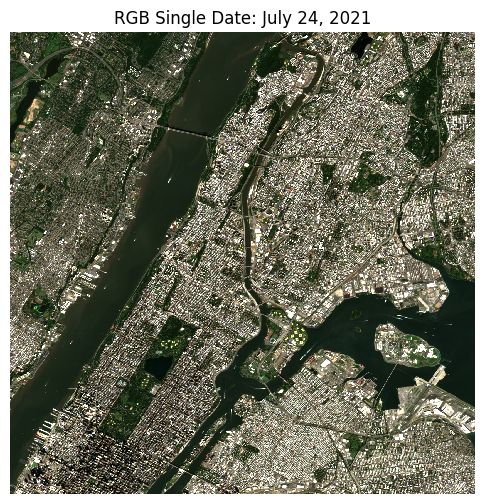

In [43]:
fig, ax = plt.subplots(figsize=(6,6))
plot_data.isel(time=7).plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Single Date: July 24, 2021")
ax.axis('off')
plt.show()

In [47]:
data_satelite1 = data_satelite.isel(time = 2)

In [48]:
height = data_satelite1.dims["latitude"]
width = data_satelite1.dims["longitude"]

In [49]:
median = data_satelite.median(dim="time").compute()

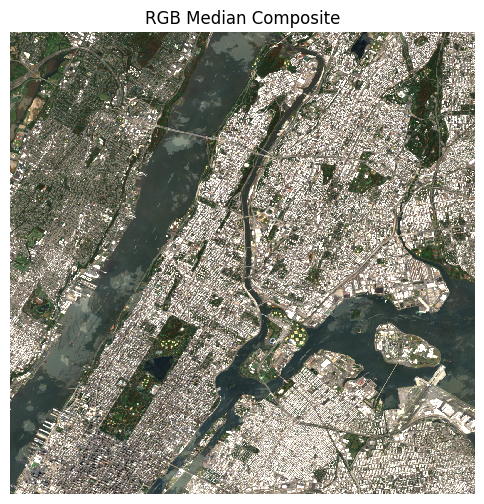

In [50]:
fig, ax = plt.subplots(figsize=(6,6))
median[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Median Composite")
ax.axis('off')
plt.show()

In [51]:
ndvi_median = (median.B08-median.B04)/(median.B08+median.B04)

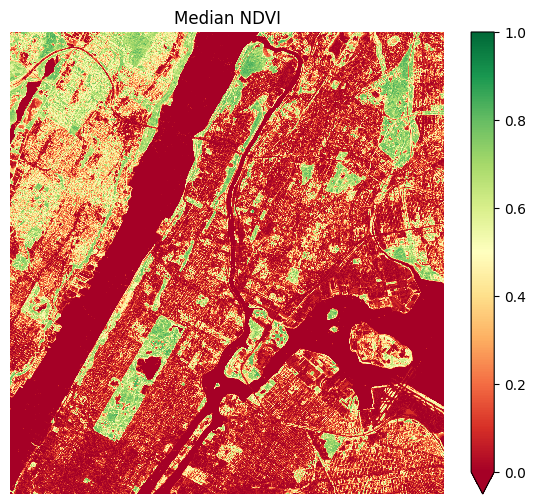

In [52]:
fig, ax = plt.subplots(figsize=(7,6))
ndvi_median.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Median NDVI")
plt.axis('off')
plt.show()

In [53]:
ndbi_median = (median.B11-median.B08)/(median.B11+median.B08)

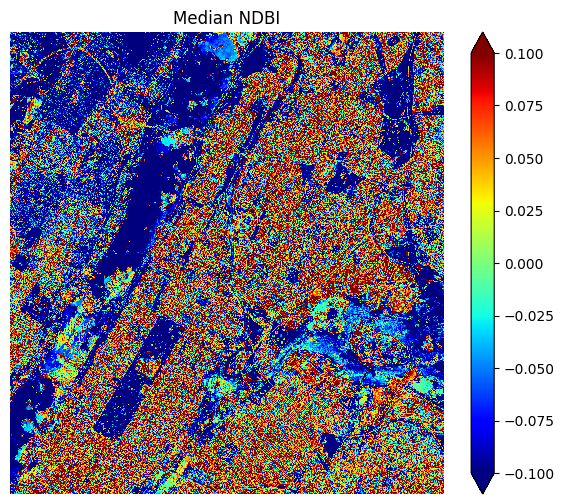

In [54]:
fig, ax = plt.subplots(figsize=(7,6))
ndbi_median.plot.imshow(vmin=-0.1, vmax=0.1, cmap="jet")
plt.title("Median NDBI")
plt.axis('off')
plt.show()

In [55]:
ndwi_median = (median.B03-median.B08)/(median.B03+median.B08)

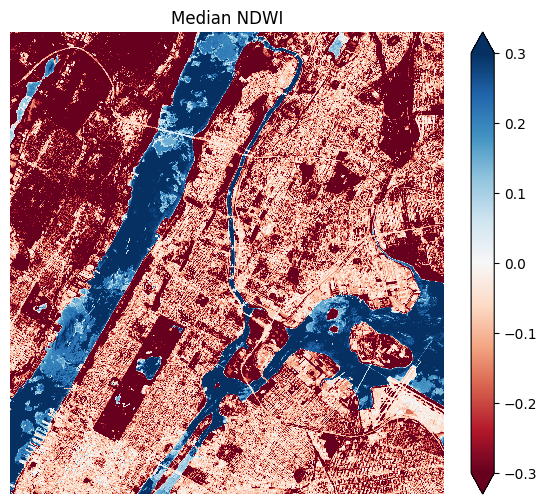

In [56]:
fig, ax = plt.subplots(figsize=(7,6))
ndwi_median.plot.imshow(vmin=-0.3, vmax=0.3, cmap="RdBu")
plt.title("Median NDWI")
plt.axis('off')
plt.show()

In [59]:
df_ndvi = ndvi_median.to_dataframe(name="value").reset_index()
df_ndwi = ndwi_median.to_dataframe(name="value").reset_index()
df_ndbi = ndbi_median.to_dataframe(name="value").reset_index()

In [68]:
satelite_df = df_ndvi.merge(df_ndwi, on=['longitude', 'latitude']).merge(df_ndbi, on=['longitude', 'latitude'])

In [70]:
value1 = []
value2 = []
value3 = []
for index, target_row in data.iterrows():
    target_longitude = data["Longitude"][index]
    target_latitude = data["Latitude"][index]

    # Calculate the Euclidean distance between the target and each row in the main dataset
    #print(target_longitude)
    satelite_df['distance'] = np.sqrt((satelite_df['longitude'] - target_longitude)**2 + (satelite_df['latitude'] - target_latitude)**2)
    
    # Find the row with the minimum distance (closest)
    closest_row = satelite_df.loc[satelite_df['distance'].idxmin()]

    # Append the closest row to target_df or a new DataFrame
    #print(closest_row)
    value1.append(closest_row['value_x'])
    value2.append(closest_row['value_y'])
    value3.append(closest_row['value'])

data['sat1'] = value1
data['sat2'] = value2
data['sat3'] = value3

In [74]:
data.drop(columns = ['datetime'],inplace = True)

In [75]:
data.head()

Longitude   Latitude  UHI Index        lst      ndvi      ndbi      ndwi  \
0 -73.909167  40.813107   1.030289  34.097490  0.471610 -0.189825 -0.472665   
1 -73.909187  40.813045   1.030289  34.097490  0.471610 -0.189825 -0.472665   
2 -73.909215  40.812978   1.023798  34.097490  0.471610 -0.189825 -0.472665   
3 -73.909242  40.812908   1.023798  34.097490  0.471610 -0.189825 -0.472665   
4 -73.909257  40.812845   1.021634  33.950515  0.455214 -0.146109 -0.447358   

       sat1      sat2      sat3  
0  0.123856 -0.140714  0.057539  
1  0.448562 -0.430494 -0.131213  
2  0.448562 -0.430494 -0.131213  
3  0.515290 -0.492470 -0.163773  
4  0.545833 -0.521035 -0.159326

# TRAINING

In [91]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [77]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

In [78]:
normalized_df = pd.DataFrame(normalized_data, columns=data.columns)

In [93]:
# Feature selection
features = ['lst', 'ndvi','ndbi','ndwi','sat1','sat2', 'sat3']
#features = ['lst','band1']

X = normalized_df[features]
y = normalized_df['UHI Index']

In [94]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [95]:
X_val

lst      ndvi      ndbi      ndwi      sat1      sat2      sat3
5961  0.335637 -0.353668  0.365266  0.362449 -0.754015  0.823486  1.300717
9683 -0.832699  3.214198 -2.884062 -3.189541  2.821373 -2.268567 -0.815826
2678 -0.485319 -0.239517  0.045620  0.230915 -0.896115  0.594827  0.073620
4194  0.266433  0.397663 -0.780323 -0.417662 -0.366083  0.388905  0.013084
5659 -1.838201  2.302353 -2.204901 -2.332183  0.713880 -0.726750 -1.539990
...        ...       ...       ...       ...       ...       ...       ...
8877  0.882489 -0.455593  0.151197  0.413883 -0.507714  0.449441  0.317234
7565  1.033111 -0.645388  0.314460  0.340957 -1.058069  0.986709  0.253268
6271  0.684374 -0.593467  0.393744  0.584806 -0.811420  1.006660  0.872721
2615  0.417054 -0.630286  0.335190  0.555434 -0.676655  0.601352  0.289690
7488  0.613813 -0.925162  0.881043  0.845171 -0.717095  0.424958 -0.771597

[2246 rows x 7 columns]

In [96]:
# Predict on validation set
y_pred = model.predict(X_val)

In [97]:
# Evaluate the model
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

MAE: 0.3665862496108791
RMSE: 0.5248218305399397
R-squared: 0.7237673618898033


In [98]:
model.feature_importances_

array([0.33617755, 0.15791787, 0.16255085, 0.12857416, 0.06508005,
       0.06944155, 0.08025798])

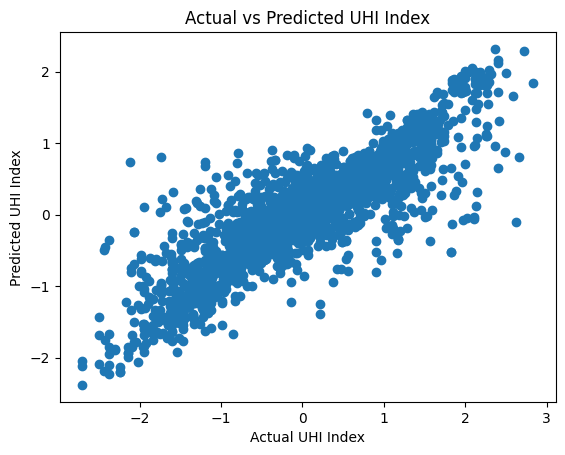

In [99]:
import matplotlib.pyplot as plt

plt.scatter(y_val, y_pred)
plt.xlabel('Actual UHI Index')
plt.ylabel('Predicted UHI Index')
plt.title('Actual vs Predicted UHI Index')
plt.show()

In [100]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(model)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_val)

In [101]:
X_test_selected

array([[ 0.33563726, -0.35366794,  0.36526557],
       [-0.83269896,  3.21419794, -2.88406192],
       [-0.48531908, -0.23951667,  0.04562033],
       ...,
       [ 0.68437409, -0.59346723,  0.39374438],
       [ 0.41705442, -0.63028597,  0.33518994],
       [ 0.61381255, -0.92516228,  0.88104299]])

In [102]:
model1 = RandomForestRegressor(n_estimators=200, random_state=42)
model1.fit(X_train_selected, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [103]:
y_pred = model1.predict(X_test_selected)

In [104]:
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

MAE: 0.25455238625901716
RMSE: 0.41547113206796954
R-squared: 0.826885711799401


# TRAINING USING PYTORCH

In [222]:
value = []
for index, target_row in test_df.iterrows():
    target_longitude = test_df["Longitude"][index]
    target_latitude = test_df["Latitude"][index]

    # Calculate the Euclidean distance between the target and each row in the main dataset
    #print(target_longitude)
    df_lst['distance'] = np.sqrt((df_lst['x'] - target_longitude)**2 + (df_lst['y'] - target_latitude)**2)
    
    # Find the row with the minimum distance (closest)
    closest_row = df_lst.loc[df_lst['distance'].idxmin()]

    # Append the closest row to target_df or a new DataFrame
    #print(closest_row)
    value.append(closest_row['lst'])

test_df['lst'] = value


In [146]:
#Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
y_train = y_train.to_numpy()  # Convert to NumPy array
y_test = y_test.to_numpy()    # Convert to NumPy array

In [149]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Step 2: Define the neural network
class UHI_Predictor(nn.Module):
    def __init__(self, input_size):
        super(UHI_Predictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
input_size = X_train.shape[1]
model = UHI_Predictor(input_size)

# Step 3: Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Step 5: Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

    # Convert predictions to numpy for evaluation
    y_pred = y_pred.numpy()
    y_test = y_test.numpy()

    # Calculate evaluation metrics
    from sklearn.metrics import mean_absolute_error, r2_score
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'R-squared: {r2:.4f}')

# Step 6: Save the model
torch.save(model.state_dict(), 'uhi_predictor.pth')

Epoch [10/100], Loss: 0.0002
Epoch [20/100], Loss: 0.0007
Epoch [30/100], Loss: 0.0004
Epoch [40/100], Loss: 0.0002
Epoch [50/100], Loss: 0.0003
Epoch [60/100], Loss: 0.0003
Epoch [70/100], Loss: 0.0003
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0002
Test Loss: 0.0003
Mean Absolute Error: 0.0135
R-squared: -0.0784


# TESTING

In [190]:
test_df = pd.read_csv("Submission_template_UHI2025-v2.csv")

In [191]:
value1 = []
value2 = []
value3 = []
value4 = []
value5 = []
for index, target_row in test_df.iterrows():
    target_longitude = test_df["Longitude"][index]
    target_latitude = test_df["Latitude"][index]

    # Calculate the Euclidean distance between the target and each row in the main dataset
    #print(target_longitude)
    df_merged['distance'] = np.sqrt((df_merged['longitude'] - target_longitude)**2 + (df_merged['latitude'] - target_latitude)**2)
    
    # Find the row with the minimum distance (closest)
    closest_row = df_merged.loc[df_merged['distance'].idxmin()]

    # Append the closest row to target_df or a new DataFrame
    #print(closest_row)
    value1.append(closest_row['lwir11'])
    value2.append(closest_row['red'])
    value3.append(closest_row['green'])
    value4.append(closest_row['blue'])
    value5.append(closest_row['nir08'])

test_df['lst'] = value1
test_df['red'] = value2
test_df['green'] = value3
test_df['blue'] = value4
test_df['nir08'] = value5

In [192]:
value1 = []
value2 = []
value3 = []
value4 = []
for index, target_row in test_df.iterrows():
    target_longitude = test_df["Longitude"][index]
    target_latitude = test_df["Latitude"][index]

    # Calculate the Euclidean distance between the target and each row in the main dataset
    #print(target_longitude)
    df_s2['distance'] = np.sqrt((df_s2['x'] - target_longitude)**2 + (df_s2['y'] - target_latitude)**2)
    
    # Find the row with the minimum distance (closest)
    closest_row = df_s2.loc[df_s2['distance'].idxmin()]

    # Append the closest row to target_df or a new DataFrame
    #print(closest_row)
    value1.append(closest_row['band1'])
    value2.append(closest_row['band2'])
    value3.append(closest_row['band3'])
    value4.append(closest_row['band4'])

test_df['band1'] = value1
test_df['band2'] = value2
test_df['band3'] = value3
test_df['band4'] = value4

In [193]:
test_df

Longitude   Latitude  UHI Index        lst       red     green  \
0    -73.971665  40.788763        NaN  31.773236  0.052752  0.059408   
1    -73.971928  40.788875        NaN  31.933883  0.067877  0.069555   
2    -73.967080  40.789080        NaN  30.754666  0.089135  0.082342   
3    -73.972550  40.789082        NaN  32.685848  0.166355  0.147710   
4    -73.969697  40.787953        NaN  30.440209  0.125105  0.121723   
...         ...        ...        ...        ...       ...       ...   
1035 -73.919388  40.813803        NaN  35.693705  0.128845  0.116085   
1036 -73.931033  40.833178        NaN  31.287878  0.143310  0.135528   
1037 -73.934647  40.854542        NaN  35.167330  0.104095  0.098293   
1038 -73.917223  40.815413        NaN  36.257679  0.305395  0.277263   
1039 -73.911645  40.804402        NaN  36.739619  0.144630  0.133273   

          blue     nir08   band1   band2   band3   band4  
0     0.033585  0.243878   811.0   432.0  2089.0  2502.0  
1     0.050992  0.256995  1208.0   745.0  2076.0  2288.0  
2     0.071342  0.187585   899.0   952.0   941.0  1168.0  
3     0.133905  0.232520  1193.0  2498.0  1939.0  2924.0  
4     0.108550  0.268985  1097.0  1688.0  2204.0  2834.0  
...        ...       ...     ...     ...     ...     ...  
1035  0.094415  0.151175  1474.0  1474.0  1553.0  1578.0  
1036  0.104150  0.282020  1014.0  2302.0  2393.0  2874.0  
1037  0.077310  0.208100  1268.0  1762.0  2040.0  1992.0  
1038  0.243273  0.354978  1890.0  1288.0  2805.0  2766.0  
1039  0.114490  0.166328  1252.0  1314.0  1645.0  1428.0  

[1040 rows x 12 columns]

In [194]:
X_test1 = test_df.drop(columns = ['UHI Index', 'Longitude', 'Latitude'])

In [202]:
X_test1 = X_test1.iloc[:, [0, 5, 1,2,3,4,6,7,8]] 

In [203]:
X_test1

lst   band1       red     green      blue     nir08   band2  \
0     31.773236   811.0  0.052752  0.059408  0.033585  0.243878   432.0   
1     31.933883  1208.0  0.067877  0.069555  0.050992  0.256995   745.0   
2     30.754666   899.0  0.089135  0.082342  0.071342  0.187585   952.0   
3     32.685848  1193.0  0.166355  0.147710  0.133905  0.232520  2498.0   
4     30.440209  1097.0  0.125105  0.121723  0.108550  0.268985  1688.0   
...         ...     ...       ...       ...       ...       ...     ...   
1035  35.693705  1474.0  0.128845  0.116085  0.094415  0.151175  1474.0   
1036  31.287878  1014.0  0.143310  0.135528  0.104150  0.282020  2302.0   
1037  35.167330  1268.0  0.104095  0.098293  0.077310  0.208100  1762.0   
1038  36.257679  1890.0  0.305395  0.277263  0.243273  0.354978  1288.0   
1039  36.739619  1252.0  0.144630  0.133273  0.114490  0.166328  1314.0   

       band3   band4  
0     2089.0  2502.0  
1     2076.0  2288.0  
2      941.0  1168.0  
3     1939.0  2924.0  
4     2204.0  2834.0  
...      ...     ...  
1035  1553.0  1578.0  
1036  2393.0  2874.0  
1037  2040.0  1992.0  
1038  2805.0  2766.0  
1039  1645.0  1428.0  

[1040 rows x 9 columns]

In [204]:
X_test1 = selector.transform(X_test1)

In [206]:
y_pred = model1.predict(X_test1)

In [207]:
y_pred

array([0.96471151, 0.96811095, 0.97534093, ..., 0.99618508, 1.03414092,
       1.02956342])

In [208]:
ans_df = pd.read_csv("Submission_template_UHI2025-v2.csv")
ans_df['UHI Index'] = y_pred

In [209]:
ans_df

Longitude   Latitude  UHI Index
0    -73.971665  40.788763   0.964712
1    -73.971928  40.788875   0.968111
2    -73.967080  40.789080   0.975341
3    -73.972550  40.789082   0.971509
4    -73.969697  40.787953   0.961771
...         ...        ...        ...
1035 -73.919388  40.813803   1.006470
1036 -73.931033  40.833178   1.041152
1037 -73.934647  40.854542   0.996185
1038 -73.917223  40.815413   1.034141
1039 -73.911645  40.804402   1.029563

[1040 rows x 3 columns]

In [210]:
ans_df.to_csv('ans1.csv', index=False)